In [109]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
%matplotlib inline

In [110]:
data = pd.read_csv('multipleChoiceResponses.csv')

C:\Users\preductor\AppData\Local\conda\conda\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I found few kernels with similar topic and desided to assemble some insights I didn't see in them. Since I'm a novice in Kaggle competitions and ML on the whole, it was interesting for me to realize which prospects I have in this area, so survey is very relevant for those who like me want to sort out what dada science really is. 

Quantity of participants in survey: 23860
Fruction representers from 15 most popular countries: 78.0%


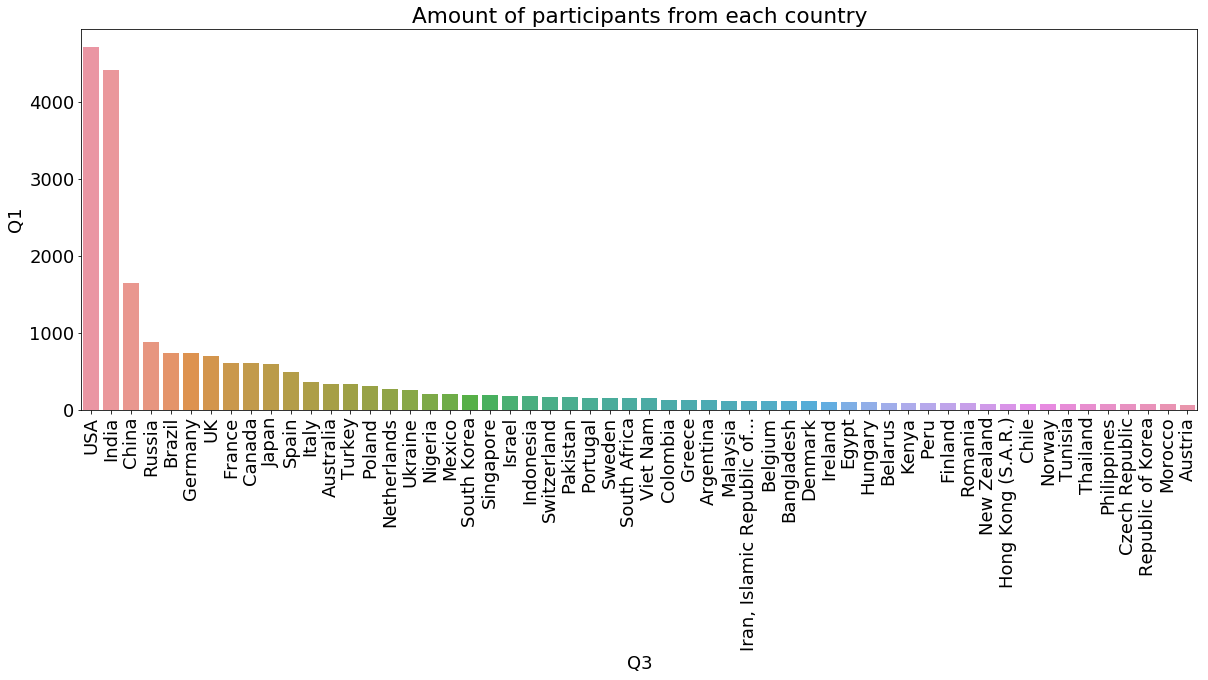

In [112]:
plt.figure(figsize=(20,7))
plt.title('Amount of participants from each country')
plt.rcParams.update({'font.size': 18})
plt.xticks(rotation='vertical')

temp = data.iloc[1:,:].groupby('Q3').agg(np.size).loc[:,['Q1','Q2']].sort_values(by='Q1', ascending=False)
temp = temp.drop(labels=['I do not wish to disclose my location',
                        'Other'],axis=0)

temp = temp.rename({'United States of America':'USA',
                           'United Kingdom of Great Britain and Northern Ireland':'UK'})

sns.barplot(x=temp.index, y=temp.Q1)

print('Quantity of participants in survey: {}'.format(np.sum(data.Q3.value_counts())))
print('Fruction representers from 15 most popular countries: {}%'.
      format(round(np.sum(temp.Q1.iloc[:15])/np.sum(temp.Q1)*100), 0))

### Observation which features from survey mostly impact salary rate 

In [113]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
fact_data = data[~data.Q9.isnull()].loc[1:,:].copy()
fact_data['Q9'] = fact_data['Q9'].replace({'0-10,000': 5000, '10-20,000':15000, '20-30,000':25000, '30-40,000':35000,'40-50,000':45000, '50-60,000':55000,
            '60-70,000':65000, '70-80,000':75000, '80-90,000':85000, '90-100,000':95000, '100-125,000':113000, '125-150,000':137000, 
            '150-200,000':175000, '200-250,000':225000, '250-300,000':275000,  '300-400,000':350000,'400-500,000':450000, '500,000+':500000,
            'I do not wish to disclose my approximate yearly compensation':-1})


for col in fact_data.drop('Q9', axis=1):
    fact_data[col].fillna('-1')
    fact_data[col] = le.fit_transform(fact_data[col].values.astype(str))

In [131]:
import lightgbm as lgb
import operator

In [ ]:
params = {
    'objective':'regression',
    'metric':'rmse',
    'nthread':4,
    'learning_rate':0.08,
    'num_leaves':31,
    'colsample_bytree':0.9,
    'subsample':0.8,
    'max_depth':5,
    'verbose':-1
}

In [133]:
train = lgb.Dataset(fact_data.drop('Q9', axis=1), fact_data.loc[:,['Q9']])
clf = lgb.train(train_set=train, num_boost_round=500)

TypeError: train() missing 1 required positional argument: 'params'

In [115]:
my_model = xgboost.XGBRegressor(max_depth=10, n_estimators=1000)
my_model.fit(fact_data.drop('Q9', axis=1), fact_data['Q9'])

In [127]:
importance_list = my_model.booster().get_score()
sorted_x = sorted(importance_list.items(), key=operator.itemgetter(1), reverse=True)

In [128]:
importance_data = pd.DataFrame(index=range(len(sorted_x)), columns=['feature', 'value'])
for idx,i in enumerate(sorted_x):
    importance_data.loc[idx,'feature'] = i[0]
    importance_data.loc[idx,'value'] = i[1]    

In [129]:
importance_data.feature[:9] = ['time from start', 'country', 'age', 'current occupation', 'industry',
        'undergraduate major', 'years of experiance', 'incorporating ML', 'level of formal education']

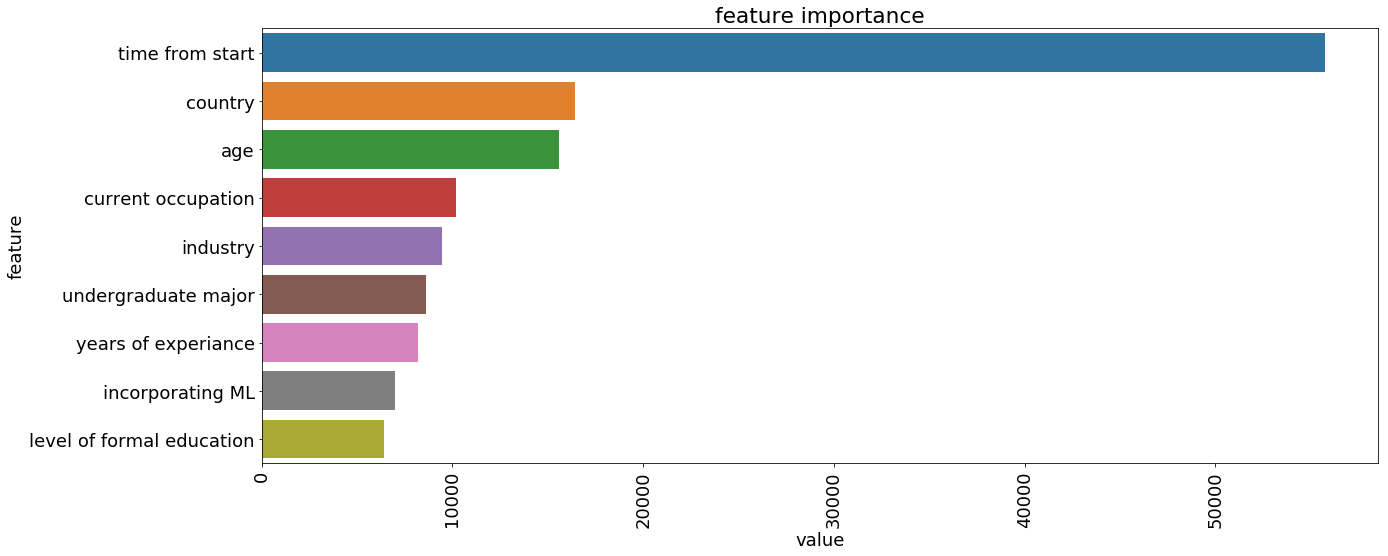

In [130]:
plt.figure(figsize=(20,8))
plt.title('feature importance')
plt.rcParams.update({'font.size': 18})

plt.xticks(rotation='vertical')
sns.barplot(y=importance_data.feature[:9], x=importance_data.value[:15])

We can see that apart from 'Time from start to finish' where model obviously overfitted, second important feature is country. It is logical. Let's have a look on salary rate in different countries

### Salary rate in different countries

In [119]:
coun_to_sal = data.loc[:,['Q3','Q9']].dropna()[data.Q6=='Data Scientist']
coun_to_sal = coun_to_sal[coun_to_sal.Q9!=
        'I do not wish to disclose my approximate yearly compensation'].iloc[1:]
coun_to_sal.rename(columns={'Q9':'wages', 'Q3':'countries'}, inplace=True)

C:\Users\preductor\AppData\Local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [120]:
coun_to_sal.wages = coun_to_sal['wages'].replace({'0-10,000': 5000, '10-20,000':15000, '20-30,000':25000, '30-40,000':35000,'40-50,000':45000, '50-60,000':55000,
            '60-70,000':65000, '70-80,000':75000, '80-90,000':85000, '90-100,000':95000, '100-125,000':113000, '125-150,000':137000, 
            '150-200,000':175000, '200-250,000':225000, '250-300,000':275000,  '300-400,000':350000,'400-500,000':450000, '500,000+':500000})

In [121]:
order = ['USA', 'Switzerland', 'Israel', 'Denmark', 'Australia', 'Republic of Korea','Canada', 
          'Norway','New Zealand', 'Hong Kong (S.A.R.)','Ireland','Singapore', 'Netherlands',
         'Germany','UK',  'Sweden', 'Finland','France','Japan',
         'Austria','Belgium','Kenya', 'Spain', 'Italy',  'South Africa', 'China', 'Mexico',
         'Argentina','Chile', 'South Korea','Brazil', 'Czech Republic','Poland',  
         'Hungary', 'Belarus','Portugal',  'Colombia',  'Thailand','Peru','Russia',  'Ukraine', 
         'Philippines','Romania', 'Malaysia', 'India', 'Morocco',
         'Greece','Bangladesh','Viet Nam','Nigeria', 'Pakistan','Turkey',
         'Iran, Islamic Republic of...','Egypt','Indonesia', 'Tunisia']

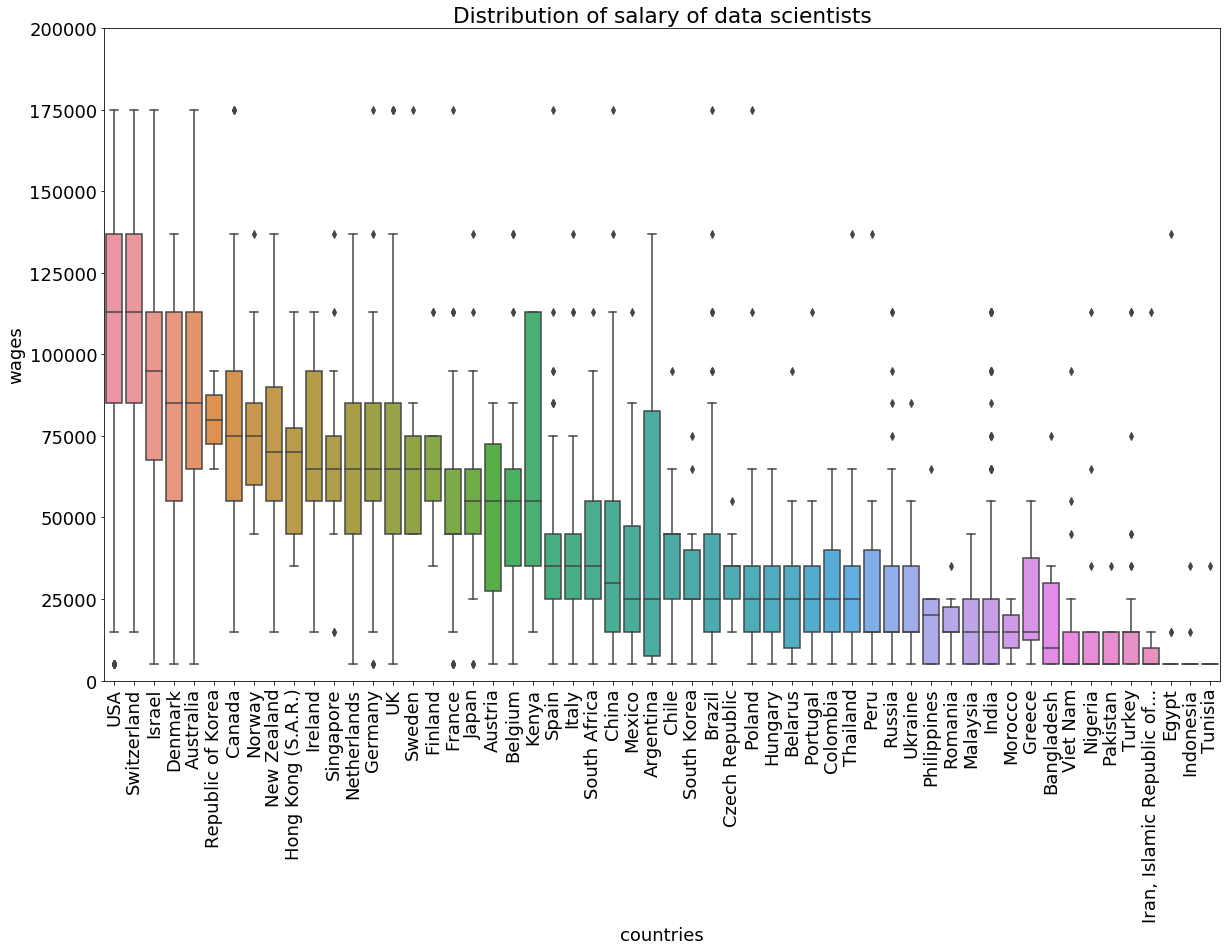

In [122]:
plt.figure(figsize=(20,12))
plt.title('Distribution of salary of data scientists')
plt.rcParams.update({'font.size': 18})
plt.xticks(rotation='vertical')
plt.ylim([0, 200000])
coun_to_sal = coun_to_sal.replace({'United States of America':'USA',
                           'United Kingdom of Great Britain and Northern Ireland':'UK'})
sns.boxplot(x='countries', y='wages', 
    data=coun_to_sal, order=order)

### Where better to be data scientist

Next I got an idea to use open data about Big Mac index (which is informal indicator of economical conditions in different countries) and to make a plot of it's value in the same list of countries in the same order. https://www.statista.com/statistics/274326/big-mac-index-global-prices-for-a-big-mac/

In [65]:
big_mac_prices = pd.DataFrame({'big_mac_prices':[5.51, 6.54, 4.68, 4.72, 4.52, np.nan, 5.07, 5.22,
    4.23, 2.55, 4.74, 4.28, 4.74, 4.74, 4.23, 5.83, 4.74, 4.74, 3.51, 4.74, 4.74,
    np.nan, 4.74, 4.74, 2.32, 3.1, 2.57, 2.71, 4.05, 4.03, 4.4, 3.4, 2.74, 3.07, np.nan, 4.74,
    4.14, 3.59, 3.21, 2.09, 1.91, 2.62, 2.32, 2.1, 2.51, np.nan, 4.74, np.nan, 2.82, np.nan, np.nan,
    2.28, np.nan, 1.75, 2.19, np.nan]}, index=order)

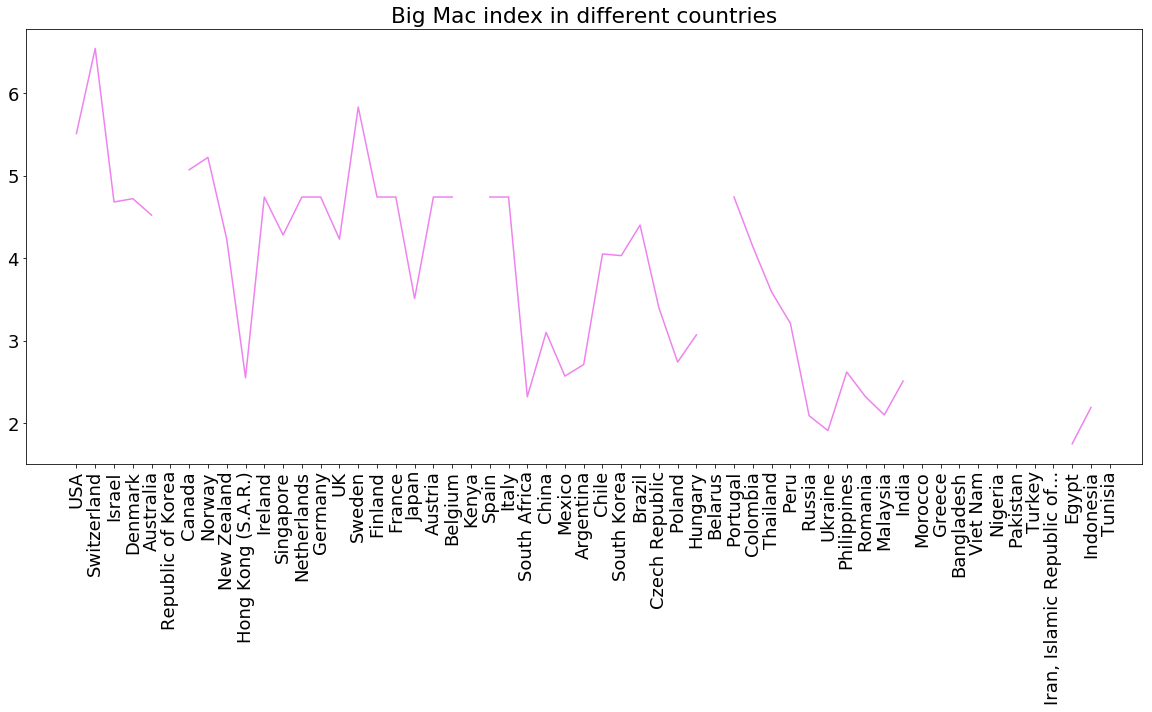

In [66]:
plt.figure(figsize=(20,8))
plt.title('Big Mac index in different countries')
plt.rcParams.update({'font.size': 18})
plt.xticks(rotation='vertical')
plt.plot(big_mac_prices, color='violet')

We can see it's not smooth like previous plot, a lot of fluctuations. Thats mean that salary doesn't directly depend on level of live in the country. And we can make inference that working as data scientist, for example, in Hong Kong, South Africa or Ukraine provides you more luxurious life there;)

### Impact of machine learning skills on salary in other jobs

Since almoust whole information for this survey was given from members of Kaggle community, I suppose majority of participants have some skills of ML and AI. That gave me an idea to compare average salary rate of people whose occupation doesn't demand knowledge of this skills with average salary of our participans on the same position

I will research USA statistics, because of enough data receaved from this survey and also because we can easily find open data about salaries on different positions in this country. For example here https://www.payscale.com/research/US/Country=United_States/Salary

In [68]:
job_order = ['Data Scientist', 'Research Assistant', 'Data Analyst',
       'Software Engineer', 'Research Scientist',
       'Data Engineer', 'Developer Advocate', 'Product/Project Manager',
       'Business Analyst', 'Principal Investigator', 'Statistician',
       'Chief Officer', 'DBA/Database Engineer',
       'Marketing Analyst', 'Salesperson', 'Data Journalist']

In [69]:
payscale_info = pd.DataFrame({'av_salary':[91470, 37184, 58555, 77897, 78028, 91277,
    100173, 81473, 59389, 70025, 79259, 160830, 111041, 53699, 42778, 62034]}, index = job_order)

In [70]:
data_usa = data[data.Q3=='United States of America'].loc[:,['Q6', 'Q9']].dropna()
data_usa = data_usa[data_usa['Q6']!='Not employed'][data_usa['Q6']!='Nan'][data_usa['Q6']!='Other']
data_usa = data_usa[data_usa['Q9']!='I do not wish to disclose my approximate yearly compensation']
data_usa['Q9'] = data_usa['Q9'].replace({'0-10,000': 5000, '10-20,000':15000, '20-30,000':25000, '30-40,000':35000,'40-50,000':45000, '50-60,000':55000,
            '60-70,000':65000, '70-80,000':75000, '80-90,000':85000, '90-100,000':95000, '100-125,000':113000, '125-150,000':137000, 
            '150-200,000':175000, '200-250,000':225000, '250-300,000':275000,  '300-400,000':350000,'400-500,000':450000, '500,000+':500000})

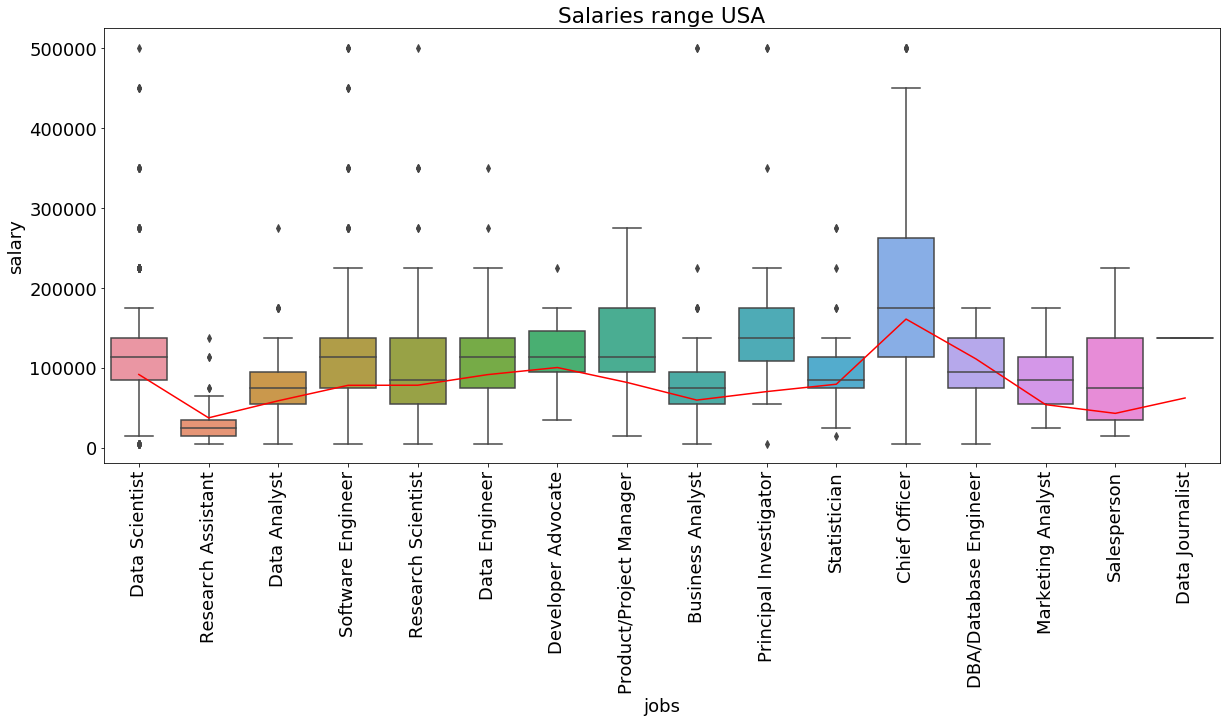

In [71]:
plt.figure(figsize=(20,8))
plt.title('Salaries range USA')
plt.rcParams.update({'font.size': 18})

plt.xticks(rotation='vertical')
sns.boxplot(x='Q6', y='Q9', data=data_usa, order=job_order)
plt.xlabel('jobs')
plt.ylabel('salary')
plt.plot(payscale_info, color='red')

Red line is statistic from reference above. We can see that, for instance, for Software Ingeneer, Product/ProjectManager, Principal Investigator or Marketing Analyst skills in machine learning and neural networks significantly increase salary rate;)

## ----------------------------------------------------------------------------------------------------

Impact of age is also logical, but I was confident that it must correlate someway with years of experiance, which could explain it's significance in our model. But surprizingly we have only 30% correlation

In [73]:
fact_data.loc[:,['Q2', 'Q8']].corr()

,Q2,Q8
Q2,1.000000,0.309167
Q8,0.309167,1.000000


Current occupation of course also makes essential influance on salary prediction. But we can found majority statistic about it, so I simply omit it

### Which industry is more lucrative

As far as I concerned data scientist can work in different areas, so for me it is quite interesting wich industry provides opportunity to earn more

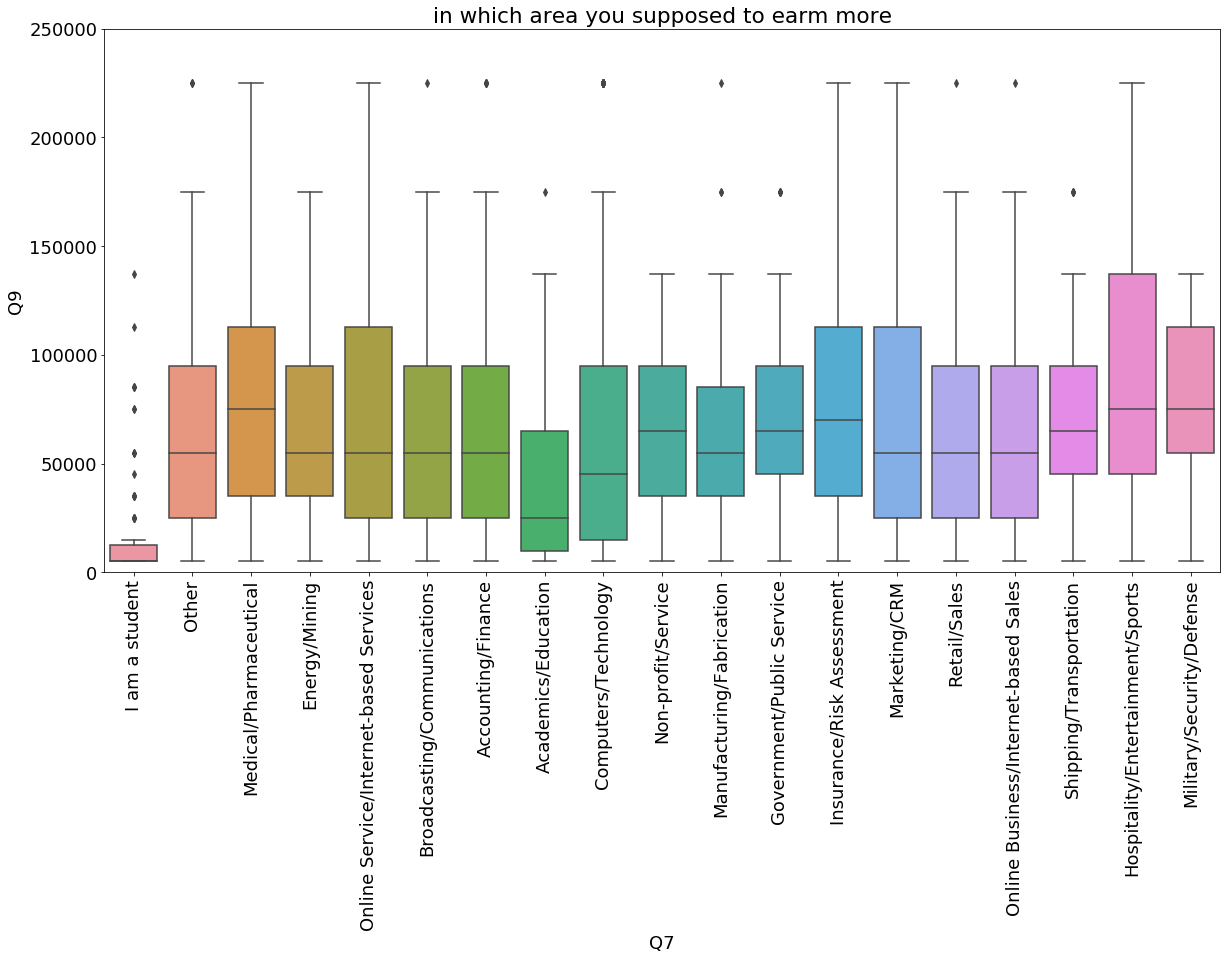

In [75]:
tran_data=data[data.Q6=='Data Scientist'].loc[1:,['Q7','Q9']].copy()
# tran_data.loc[:,['Q7','Q9']] = data.loc[:,['Q7','Q9']]
tran_data['Q9'] = tran_data['Q9'].replace({'0-10,000': 5000, '10-20,000':15000, '20-30,000':25000, '30-40,000':35000,'40-50,000':45000, '50-60,000':55000,
            '60-70,000':65000, '70-80,000':75000, '80-90,000':85000, '90-100,000':95000, '100-125,000':113000, '125-150,000':137000, 
            '150-200,000':175000, '200-250,000':225000, '250-300,000':275000,  '300-400,000':350000,'400-500,000':450000, '500,000+':500000})
tran_data = tran_data[tran_data.Q9!='I do not wish to disclose my approximate yearly compensation']

tran_data.dropna(inplace=True)
tran_data['Q9']=tran_data['Q9'].astype('int64')

plt.figure(figsize=(20,10))
plt.title('in which area you supposed to earm more')
plt.rcParams.update({'font.size': 18})
plt.ylim([0, 250000])

plt.xticks(rotation='vertical')

sns.boxplot(x='Q7', y='Q9', data=tran_data)

Medical/Pharmaceutical, Entertetainment/Sports, Risk Assessment and Security/Defence seems like resonable areas to work in:)

## ----------------------------------------------------------------------------------------------

### Online vs Offline

One more feature that I want to investigate is availability of formal education for Machine Learning specialization in different countries. Since data science is one of the youngest sciences in IT, at least in my country, Russia, not many universities provide such degree. So most of specialists from here might study via online courses. Let's check situation in different countries

In [91]:
courses_vs_university = data.loc[1:,['Q3','Q35_Part_1','Q35_Part_2','Q35_Part_3',
                    'Q35_Part_4','Q35_Part_5','Q35_Part_6']].dropna()
countries = courses_vs_university.loc[:,['Q3']]

In [92]:
courses_vs_university = courses_vs_university.loc[:,['Q35_Part_1','Q35_Part_2','Q35_Part_3',
                    'Q35_Part_4','Q35_Part_5','Q35_Part_6']].astype('float', copy=False)
courses_vs_university['Q3'] = countries

In [105]:
cour_vs_uni_corr = courses_vs_university.groupby(['Q3']).apply(lambda df: np.mean(df))
cour_vs_uni_corr.rename({'United States of America':'USA',
                           'United Kingdom of Great Britain and Northern Ireland':'UK'},columns={'Q35_Part_1':'Self-taught', 'Q35_Part_2':'Online', 'Q35_Part_3':'Work',
                'Q35_Part_4':'University', 'Q35_Part_5':'Kaggle', 'Q35_Part_6':'Other'}, inplace=True)
cour_vs_uni_corr = cour_vs_uni_corr.drop(labels=['I do not wish to disclose my location',
                        'Other'],axis=0)

cour_vs_uni_corr.index.name='country'

In [107]:
cour_vs_uni_corr['Ratio'] = cour_vs_uni_corr['Online'] / cour_vs_uni_corr['University']
cour_vs_uni_corr.sort_values(by='Ratio', ascending=False, inplace=True)

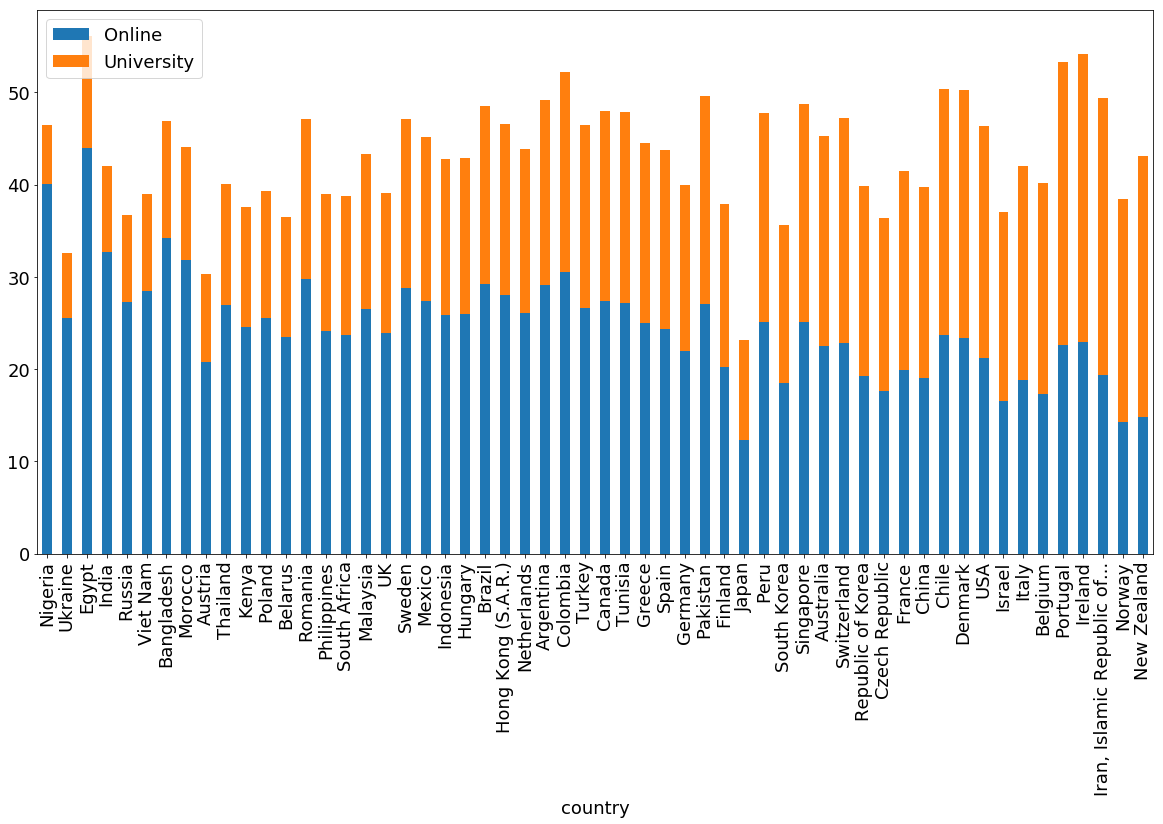

In [108]:
cour_vs_uni_corr.loc[:,['Online','University']].plot.bar(figsize=(20,10),stacked=True)

On the left- countries where tuition mostly available only through online corses and on the right- countries, in which citizens have opportunity to get university degree 